In [56]:
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.layers import Dense, LeakyReLU, SimpleRNN, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras import models
from keras import layers

from mlflow.models import infer_signature
import mlflow.tensorflow
import mlflow.sklearn
import mlflow

from dotenv import load_dotenv
import logging
import requests
import os

## Load Dataset

In [3]:
load_dotenv('.env')
TOKEN=os.getenv('TOKEN')

In [4]:
URL=f"https://api.tiingo.com/tiingo/crypto/prices"

params = {
    "tickers":"btcusd",
    "startDate":"2024-01-02",
    "token":TOKEN,
    "resampleFreq":"1day"
}

headers = {
    'Content-Type': 'application/json'
}

In [7]:
response = requests.get(URL, headers=headers, params=params)

In [20]:
df = pd.DataFrame(response.json()[0]['priceData'])

In [21]:
df.head()

,date,open,high,low,close,volume,volumeNotional,tradesDone
0,2024-01-02T00:00:00+00:00,44211.061415,45923.924577,44188.523853,44974.051985,40068.108280,1.802025e+09,543927.0
1,2024-01-03T00:00:00+00:00,44975.949864,45521.023287,40619.777448,42862.351210,44075.068839,1.889161e+09,650108.0
2,2024-01-04T00:00:00+00:00,42861.297084,44799.410744,42654.412086,44195.296702,24879.776525,1.099569e+09,385907.0
3,2024-01-05T00:00:00+00:00,44199.961673,44431.360637,42455.208228,44186.809326,25565.207217,1.129645e+09,395564.0
4,2024-01-06T00:00:00+00:00,44188.013965,44258.936266,43439.232078,43994.115485,7832.320838,3.445760e+08,190681.0


In [29]:
df_close = df['close']
print(df_close.head())
print(df_close.tail())

0    44974.051985
1    42862.351210
2    44195.296702
3    44186.809326
4    43994.115485
Name: close, dtype: float64
439    82573.488763
440    84029.276451
441    82726.486819
442    86879.448404
443    85854.738101
Name: close, dtype: float64


## Data Visualization

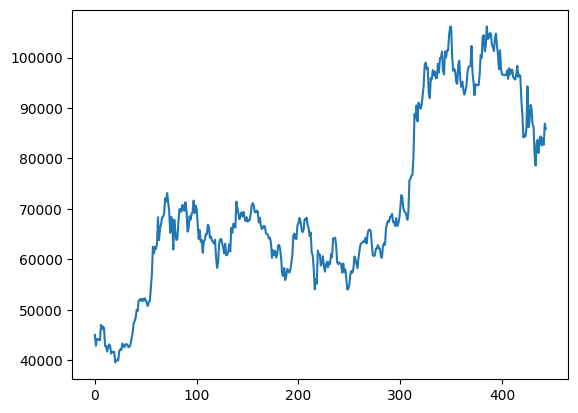

In [37]:
plt.plot(df_close)

## Data Preprocessing

Dataset version:
- v1: MinMax Scaler
- v2: Standard Scaler

- ### MinMax Scaler

In [30]:
scaler = MinMaxScaler()

In [31]:
df_v1 = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [32]:
df_v1

array([[0.08169691],
       [0.05000299],
       [0.07000879],
       [0.06988141],
       [0.06698932],
       [0.06628985],
       [0.1119371 ],
       [0.09894663],
       [0.107098  ],
       [0.10225443],
       [0.04873003],
       [0.04966654],
       [0.03262919],
       [0.04444981],
       [0.05404213],
       [0.0481911 ],
       [0.02643661],
       [0.03149223],
       [0.03240185],
       [0.03082816],
       [0.        ],
       [0.00525721],
       [0.00826953],
       [0.00622736],
       [0.03429085],
       [0.03895479],
       [0.03756215],
       [0.05663152],
       [0.051238  ],
       [0.04535393],
       [0.05324016],
       [0.05481316],
       [0.05213865],
       [0.04565148],
       [0.046983  ],
       [0.05347584],
       [0.0721771 ],
       [0.08665535],
       [0.11446261],
       [0.12366635],
       [0.13183536],
       [0.15626998],
       [0.15309936],
       [0.18484703],
       [0.1861273 ],
       [0.18958064],
       [0.18209738],
       [0.189

- ### Standard Scaler

In [33]:
scaler = StandardScaler()

In [35]:
df_v2 = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [36]:
df_v2

array([[-1.49794185e+00],
       [-1.61896733e+00],
       [-1.54257375e+00],
       [-1.54306018e+00],
       [-1.55410382e+00],
       [-1.55677478e+00],
       [-1.38246755e+00],
       [-1.43207255e+00],
       [-1.40094597e+00],
       [-1.41944150e+00],
       [-1.62382822e+00],
       [-1.62025207e+00],
       [-1.68531041e+00],
       [-1.64017252e+00],
       [-1.60354358e+00],
       [-1.62588614e+00],
       [-1.70895720e+00],
       [-1.68965196e+00],
       [-1.68617852e+00],
       [-1.69218775e+00],
       [-1.80990728e+00],
       [-1.78983225e+00],
       [-1.77832949e+00],
       [-1.78612765e+00],
       [-1.67896523e+00],
       [-1.66115564e+00],
       [-1.66647354e+00],
       [-1.59365580e+00],
       [-1.61425133e+00],
       [-1.63672010e+00],
       [-1.60660597e+00],
       [-1.60059933e+00],
       [-1.61081216e+00],
       [-1.63558387e+00],
       [-1.63049938e+00],
       [-1.60570601e+00],
       [-1.53429392e+00],
       [-1.47900767e+00],
       [-1.3

- ### Train Test Split

In [41]:
TRAIN_SIZE = int(len(df) * .65) # Train 65% and Test 35%
TEST_SIZE = len(df) - TRAIN_SIZE

In [43]:
def split(df, train_size):
    return df[0:train_size, 0], df[train_size+1:len(df), 0]

In [45]:
train_df_v1, test_df_v1 = split(df_v1, TRAIN_SIZE)
train_df_v2, test_df_v2 = split(df_v2, TRAIN_SIZE)

- ### Converts Time Series Data into pairs of Input (X) and Output (y)

In [49]:
def create_dataset(df, time_step=1):
    '''
    This function used to converts a sequence of time series data into pairs of input (X) and output (y).
    This function creates sliding windows of past observations to predict the next value
    '''
    data_X, data_y = [], []
    for i in range(len(df)-time_step-1):
        temp = df[i:(i+time_step)]
        data_X.append(temp)
        data_y.append(df[i +time_step])
    return np.array(data_X), np.array(data_y)

In [39]:
TIME_STEP = 100

In [50]:
X_train_v1, y_train_v1 = create_dataset(train_df_v1, TIME_STEP)
X_train_v2, y_train_v2 = create_dataset(train_df_v2, TIME_STEP)
X_test_v1, y_test_v1 = create_dataset(test_df_v1, TIME_STEP)
X_test_v2, y_test_v2 = create_dataset(test_df_v2, TIME_STEP)